<a href="https://colab.research.google.com/github/Edudeiko/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Evgenii_Dudeiko_DSPT3_assignment_regression_classification_313.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [0]:
import numpy as np
from scipy import stats

In [0]:
# Filter these warnings:
# sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered
# scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered
warnings.filterwarnings(action='ignore', category=RuntimeWarning, module='sklearn')
warnings.filterwarnings(action='ignore', category=RuntimeWarning, module='scipy')

In [447]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [0]:
# Predict property sales prices for One Family Dwellings (BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS').

In [448]:
df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']
print(df.shape)
df.sample(3)

(5061, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
10422,5,OTHER,01 ONE FAMILY DWELLINGS,1,5375,30,NaN,A2,148 HALES AVENUE,NaN,10312.0,1.0,0.0,1.0,"5,700",1440.0,1955.0,1,A2,318000,02/21/2019
713,5,OTHER,01 ONE FAMILY DWELLINGS,1,4666,4,NaN,A1,258 GUYON AVENUE,NaN,10306.0,1.0,0.0,1.0,"4,000",1384.0,1910.0,1,A1,560000,01/04/2019
15675,5,OTHER,01 ONE FAMILY DWELLINGS,1,5444,65,NaN,A1,42 ARKANSAS AVENUE,NaN,10308.0,1.0,0.0,1.0,"4,320",1680.0,1975.0,1,A1,0,03/19/2019


In [0]:
# Use a subset of the data where the sale price was more than $100 thousand and less than $2 million.

In [449]:
df['SALE_PRICE'].value_counts()

0         1681
10          64
500000      48
550000      43
450000      40
          ... 
506113       1
880888       1
588005       1
332000       1
987000       1
Name: SALE_PRICE, Length: 1106, dtype: int64

In [0]:
df = df[df['SALE_PRICE'] <= 2000000]

In [451]:
df = df[df['SALE_PRICE'] >= 100000]
print(df.shape)
df.sample(3)

(3164, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
1991,4,OTHER,01 ONE FAMILY DWELLINGS,1D,16350,400,NaN,A8,"11 ESSEX WALK, 542",NaN,11697.0,0.0,0.0,0.0,0,0.0,1938.0,1,A8,225000,01/11/2019
21444,4,OTHER,01 ONE FAMILY DWELLINGS,1,1245,47,NaN,A5,33-41 72ND STREET,NaN,11372.0,1.0,0.0,1.0,"2,000",1400.0,1930.0,1,A5,857500,04/17/2019
22462,3,OTHER,01 ONE FAMILY DWELLINGS,1,8406,21,NaN,A9,2032 EAST 64TH STREET,NaN,11234.0,1.0,0.0,1.0,"2,000",1650.0,1925.0,1,A9,540000,04/25/2019


In [0]:
# I decided to drop 2 columns with 3163 & 3164 NaN values out of 3164 in total rows

In [452]:
df.isna().sum()

BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING_CLASS_CATEGORY              0
TAX_CLASS_AT_PRESENT                 0
BLOCK                                0
LOT                                  0
EASE-MENT                         3164
BUILDING_CLASS_AT_PRESENT            0
ADDRESS                              0
APARTMENT_NUMBER                  3163
ZIP_CODE                             0
RESIDENTIAL_UNITS                    0
COMMERCIAL_UNITS                     0
TOTAL_UNITS                          0
LAND_SQUARE_FEET                     0
GROSS_SQUARE_FEET                    0
YEAR_BUILT                           0
TAX_CLASS_AT_TIME_OF_SALE            0
BUILDING_CLASS_AT_TIME_OF_SALE       0
SALE_PRICE                           0
SALE_DATE                            0
dtype: int64

In [0]:
df = df.drop(columns=['EASE-MENT', 'APARTMENT_NUMBER'])

In [454]:
df.isna().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [0]:
# Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [455]:
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [0]:
# Need to transform SALE_DATE to 'datetime' first

In [456]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df.dtypes

BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE                         datetime64[ns]
dtype: object

In [0]:
mask = df['SALE_DATE'] >= pd.to_datetime('2019-04-01')
test = df[mask]
train = df[~mask]

In [458]:
test.shape, train.shape

((647, 19), (2517, 19))

In [459]:
test.sample(3)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
19002,3,OTHER,01 ONE FAMILY DWELLINGS,1,8203,22,A5,1205 EAST 95TH STREET,11236.0,1.0,0.0,1.0,"2,115",956.0,1925.0,1,A5,565000,2019-04-04
21974,3,OTHER,01 ONE FAMILY DWELLINGS,1,4980,30,A9,1324 SCHENECTADY AVENUE,11203.0,1.0,0.0,1.0,"2,400",1312.0,1920.0,1,A9,650000,2019-04-22
19913,4,OTHER,01 ONE FAMILY DWELLINGS,1,6640,34,A5,144-43 69TH ROAD,11367.0,1.0,0.0,1.0,"1,678",1260.0,1940.0,1,A5,700000,2019-04-09


In [460]:
train.sample(3)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
6547,2,OTHER,01 ONE FAMILY DWELLINGS,1,4324,61,A5,2145 BOGART AVE,10462.0,1.0,0.0,1.0,"1,800",1842.0,1940.0,1,A5,578000,2019-02-01
6135,2,OTHER,01 ONE FAMILY DWELLINGS,1,4759,31,S1,3127 SEYMOUR AVENUE,10469.0,1.0,1.0,2.0,"2,272",3468.0,1920.0,1,S1,406282,2019-01-31
1405,4,OTHER,01 ONE FAMILY DWELLINGS,1,12772,212,A1,118-20 236TH STREET,11411.0,1.0,0.0,1.0,"4,400",1650.0,1945.0,1,A1,580000,2019-01-09


In [0]:
# Do one-hot encoding of categorical features

In [461]:
train.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
BLOCK,2517.0,6750.859754,3977.126707,21.0,3818.0,6021.0,9879.0,16350.0
LOT,2517.0,75.674215,157.232723,1.0,21.0,42.0,70.0,2720.0
ZIP_CODE,2517.0,10993.891538,494.054748,10301.0,10314.0,11234.0,11413.0,11697.0
RESIDENTIAL_UNITS,2517.0,0.987684,0.110315,0.0,1.0,1.0,1.0,1.0
COMMERCIAL_UNITS,2517.0,0.016289,0.129712,0.0,0.0,0.0,0.0,2.0
TOTAL_UNITS,2517.0,1.003973,0.171453,0.0,1.0,1.0,1.0,3.0
GROSS_SQUARE_FEET,2517.0,1473.500596,599.132016,0.0,1144.0,1367.0,1683.0,7875.0
YEAR_BUILT,2517.0,1944.729837,27.054972,1890.0,1925.0,1940.0,1960.0,2018.0
TAX_CLASS_AT_TIME_OF_SALE,2517.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
SALE_PRICE,2517.0,621011.272149,295079.398887,100000.0,440000.0,560000.0,750000.0,2000000.0


In [462]:
train.describe(exclude='number').T

,count,unique,top,freq,first,last
BOROUGH,2517,5,4,1209,NaT,NaT
NEIGHBORHOOD,2517,6,OTHER,2390,NaT,NaT
BUILDING_CLASS_CATEGORY,2517,1,01 ONE FAMILY DWELLINGS,2517,NaT,NaT
TAX_CLASS_AT_PRESENT,2517,2,1,2486,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2517,13,A1,921,NaT,NaT
ADDRESS,2517,2507,117-45 125TH STREET,2,NaT,NaT
LAND_SQUARE_FEET,2517,889,"4,000",235,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2517,11,A1,921,NaT,NaT
SALE_DATE,2517,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30


In [463]:
train.groupby('BOROUGH')['SALE_PRICE'].mean()

BOROUGH
1    739000.000000
2    473104.623967
3    773207.940150
4    646734.679901
5    535988.615964
Name: SALE_PRICE, dtype: float64

In [464]:
train.groupby('TAX_CLASS_AT_PRESENT')['SALE_PRICE'].mean()

TAX_CLASS_AT_PRESENT
1     623855.781175
1D    392900.000000
Name: SALE_PRICE, dtype: float64

In [465]:
train['TAX_CLASS_AT_PRESENT'].value_counts()

1     2486
1D      31
Name: TAX_CLASS_AT_PRESENT, dtype: int64

In [0]:
# I'm keeping 'BOROUGH' and 'TAX_CLASS_AT_PRESENT, the rest of the categorical features have high cardinality.
# I excluded them.

In [0]:
target = 'SALE_PRICE'
high_cardinality = ['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'ADDRESS',
                    'BUILDING_CLASS_AT_PRESENT', 'LAND_SQUARE_FEET', 
                    'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [467]:
print(X_train.shape, X_test.shape)
X_train.head()

(2517, 11) (647, 11)


,BOROUGH,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,3,1,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1
61,4,1,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1
78,2,1,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1
108,3,1,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1
111,3,1,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1


In [0]:
import category_encoders as ce

In [0]:
# IMPORTANT!
# .fit_transform on the train set
# .transform on test set
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [470]:
print(X_train.shape, X_test.shape)
X_train.head()

(2517, 16) (647, 16)


,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,1,0,0,0,0,1,0,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1
61,0,1,0,0,0,1,0,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1
78,0,0,1,0,0,1,0,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1
108,1,0,0,0,0,1,0,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1
111,1,0,0,0,0,1,0,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1


In [471]:
X_test.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
18235,0,0,1,0,0,1,0,5913,878,10471.0,1.0,0.0,1.0,2272.0,1930.0,1
18239,0,0,1,0,0,1,0,5488,48,10465.0,1.0,0.0,1.0,720.0,1935.0,1
18244,1,0,0,0,0,1,0,5936,31,11209.0,1.0,0.0,1.0,2210.0,1925.0,1
18280,1,0,0,0,0,1,0,7813,24,11210.0,1.0,0.0,1.0,1520.0,1915.0,1
18285,1,0,0,0,0,1,0,8831,160,11229.0,1.0,0.0,1.0,840.0,1925.0,1


In [0]:
# Do feature selection with SelectKBest

In [0]:
from sklearn.feature_selection import f_regression, SelectKBest

In [473]:
X_train.shape, X_test.shape

((2517, 16), (647, 16))

In [474]:
selector = SelectKBest(score_func=f_regression, k=8)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape

(2517, 8)

In [475]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features Selected:')
for name in selected_names:
  print(name)

print('')
print('Features Not Selected:')
for name in unselected_names:
  print(name)

Features Selected:
BOROUGH_3
BOROUGH_2
BOROUGH_5
BLOCK
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET

Features Not Selected:
BOROUGH_4
BOROUGH_1
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
LOT
RESIDENTIAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [477]:
for k in range(1, len(X_train.columns) + 1):
  print(f'{k} features:')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test MAE: ${mae:,.0f} \n')

1 features:
Test MAE: $185,788 

2 features:
Test MAE: $186,656 

3 features:
Test MAE: $185,097 

4 features:
Test MAE: $185,607 

5 features:
Test MAE: $178,918 

6 features:
Test MAE: $168,465 

7 features:
Test MAE: $167,926 

8 features:
Test MAE: $169,357 

9 features:
Test MAE: $169,357 

10 features:
Test MAE: $169,154 

11 features:
Test MAE: $169,067 

12 features:
Test MAE: $169,127 

13 features:
Test MAE: $169,137 

14 features:
Test MAE: $169,167 

15 features:
Test MAE: $169,167 

16 features:
Test MAE: $169,167 



In [0]:
# Do feature scaling

In [480]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_selected)
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

X_train_scaled

array([[ 2.29713038, -0.96141142, -0.3261497 , ..., -0.24790881,
        -0.54454923,  0.        ],
       [-0.43532575,  1.04013742, -0.3261497 , ...,  0.8806143 ,
        -0.17485795,  0.        ],
       [-0.43532575, -0.96141142,  3.06607672, ...,  0.95072964,
        -0.72939487,  0.        ],
       ...,
       [-0.43532575, -0.96141142, -0.3261497 , ...,  0.5567482 ,
         2.70873401,  0.        ],
       [-0.43532575, -0.96141142, -0.3261497 , ..., -1.42317548,
        -0.54454923,  0.        ],
       [-0.43532575,  1.04013742, -0.3261497 , ..., -0.5183537 ,
         0.19483333,  0.        ]])

In [0]:
# Fit a ridge regression model with multiple features.

In [0]:
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

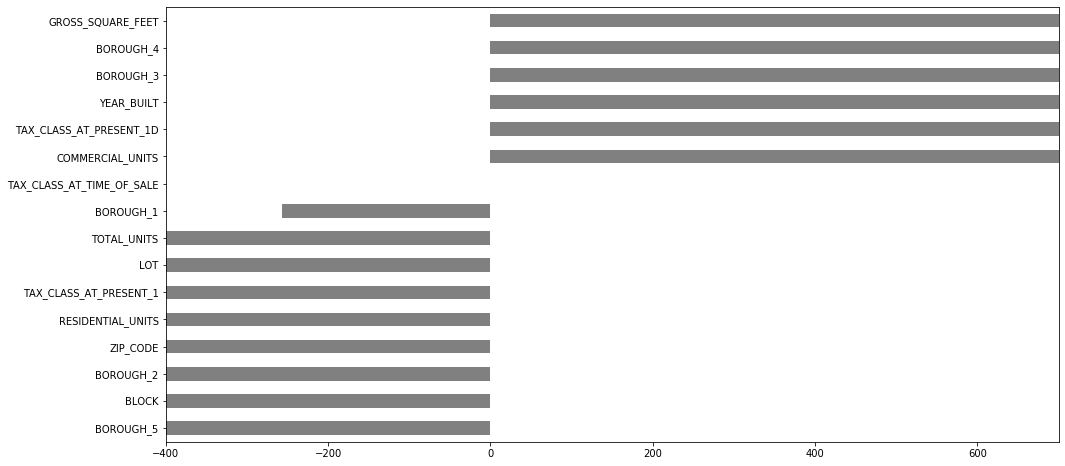

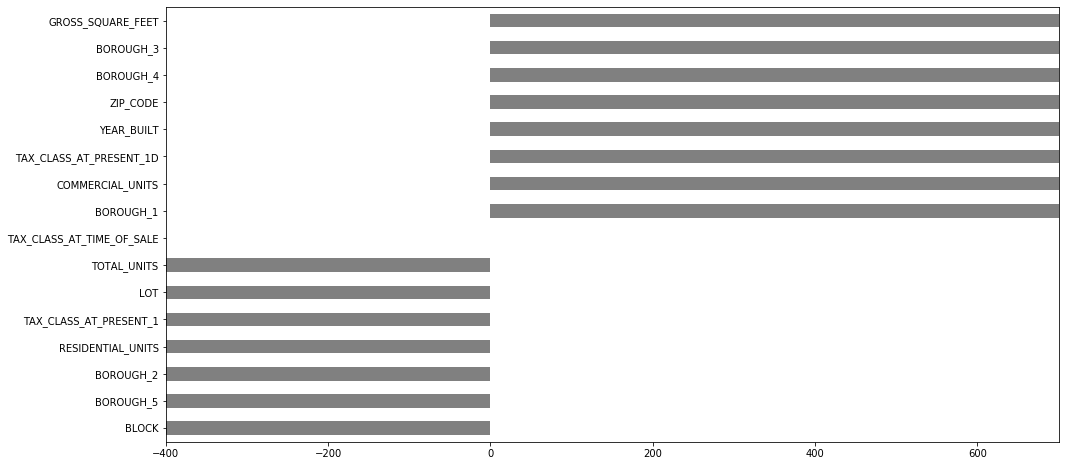

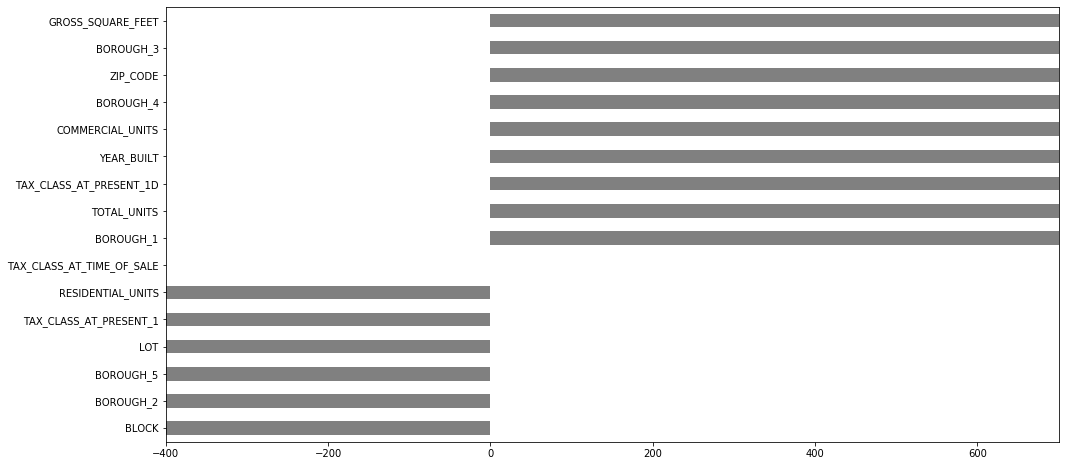

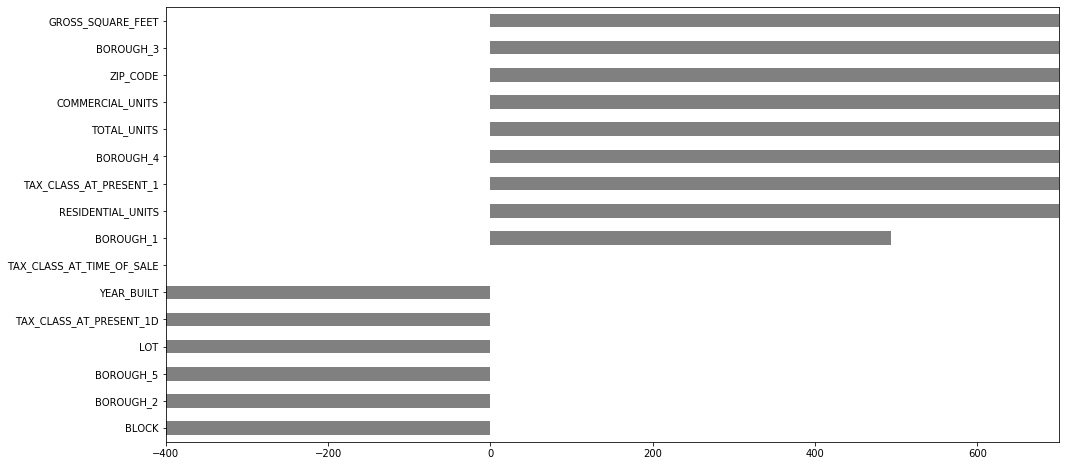

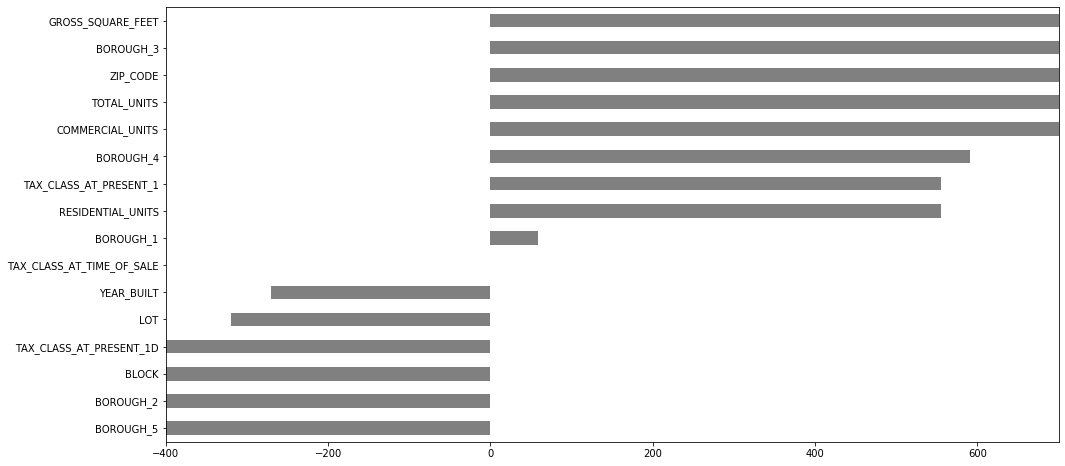

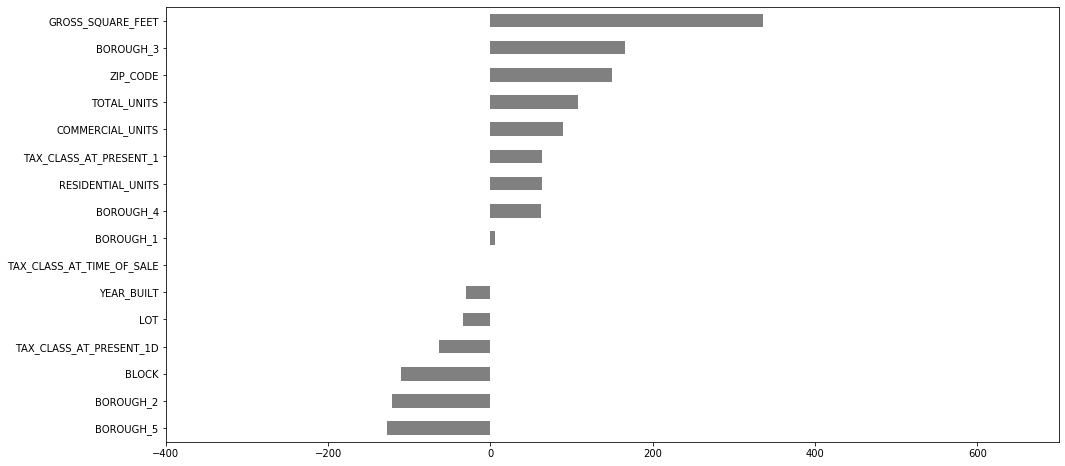

In [482]:
for alpha in [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]:
    
    # Scale data before doing Ridge Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,700)
    plt.show()